<h1> Классификация спама в e-mail сообщениях

<h3>Обработка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np          
import seaborn as sns         
import sklearn
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')


train_dataset = []
test_dataset = []
dataset = []

train_dataset = pd.read_csv("archive/SMS_train.csv", sep=',', encoding="Windows-1252")
test_dataset = pd.read_csv("archive/SMS_test.csv", sep=',', encoding="Windows-1252")

dataset = pd.concat((train_dataset, test_dataset), ignore_index=True)
#dataset = train_dataset

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mievs\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mievs\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import warnings
warnings.filterwarnings("ignore")

<h3> Получаем набор всех слов встречающихся в выборке (Составляем "Мешок слов")

In [3]:
tokens = []


for xl in dataset["Message_body"]:
    token = nltk.word_tokenize(str(xl).lower())
    token = [t for t in token if len(t) > 2]
    for t in token:
        tokens.append(t)
tokens = set(tokens)
tokens = list(tokens)

In [4]:
def gram_tokens(tokens, gram = 2):
    if gram > 1:
        t = []
        for i in range(len(tokens) - gram + 1): 
            t += [" ".join(tokens[i:i + gram])]
        return t

def process_tokens(tokens, stem = True, stop_words = True):
    if stop_words:
        sw = stopwords.words("english")
        tokens = [token for token in tokens if token not in sw]
    if stem:
        stemmer = nltk.PorterStemmer()
        tokens = [stemmer.stem(token) for token in tokens]
    return tokens

In [5]:
#tokens = gram_tokens(tokens, 2)
tokens = process_tokens(tokens, True, True)

In [6]:
#количество неповторяющихся слов
tokens.__len__()

3428

<h3> Обрабатываем датасет. Теперь для каждой записи указано сколько раз встречается то или иное слово в сообщении

In [7]:
from collections import Counter

def bag_of_words(tokens, dataset):
    df = pd.DataFrame(dataset)
    for index, row in dataset.iterrows():
        msg_tokens = nltk.word_tokenize(str(row["Message_body"]).lower())
        msg_tokens = [t for t in msg_tokens if len(t) > 2]
        #msg_tokens = gram_tokens(msg_tokens, 2)
        msg_tokens = process_tokens(msg_tokens, True, True)
        count_letter = Counter(msg_tokens)
        for token in tokens:
            df.loc[index, token] = count_letter[token]
    return df.copy()

df = bag_of_words(tokens, dataset)


df.drop("Message_body", axis=1, inplace=True)

In [8]:
df.drop("S. No.", axis=1, inplace=True)

In [9]:
df.iloc[:,0] = df.iloc[:,0].astype('category')

<h3> Нормализуем данные

In [10]:
categorical_columns = [c for c in df.columns if df[c].dtype.name == 'category']
numerical_columns   = [c for c in df.columns if df[c].dtype.name != 'category']

In [11]:
for col_num in numerical_columns:
    if  not df[col_num].std(axis = 0):
        print(df[col_num])
        df.drop(col_num, axis=1, inplace=True)
        numerical_columns.remove(col_num)

In [12]:
data_numerical = df[numerical_columns]
data_numerical = (data_numerical - data_numerical.mean(axis = 0))/data_numerical.std(axis = 0)

In [13]:
data = pd.concat((data_numerical, df['Label']), axis = 1)

In [14]:
X = data.drop('Label', axis = 1)
y = data['Label']

<h3> Разбиваем данные на тренировочную и тестовую выборку

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state = 50)

In [16]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

<h3>Подбор гиперпараметров

<h5>Один слой

In [17]:
alpha_arr = np.logspace(-3, 2, 21)
test_err = []
train_err = []
train_acc = []
test_acc = []

for alpha in alpha_arr:
    mlp_model = MLPClassifier(alpha = alpha, hidden_layer_sizes = (100,), 
                              solver = 'lbfgs', activation = 'logistic', max_iter=1000, random_state = 42)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))

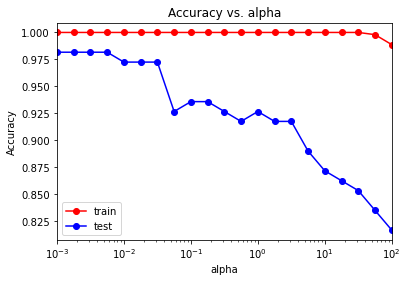

In [18]:
plt.semilogx(alpha_arr, train_acc, 'r-o', label = 'train')
plt.semilogx(alpha_arr, test_acc, 'b-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Accuracy vs. alpha')
plt.xlabel('alpha')
plt.ylabel('Accuracy')
plt.legend()

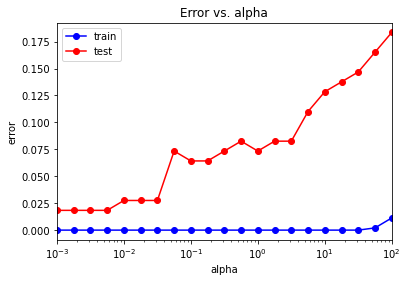

In [19]:
plt.semilogx(alpha_arr, train_err, 'b-o', label = 'train')
plt.semilogx(alpha_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()

При малых alpha точность выше

In [20]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.0 0.01834862385321101


In [21]:
alpha_opt = alpha_arr[test_err == min_test_err]
print(alpha_opt)

[0.001      0.00177828 0.00316228 0.00562341]


In [22]:
alpha_opt_one_layer = alpha_opt[0]

<h5>Два слоя

In [23]:
test_err = []
train_err = []
train_acc = []
test_acc = []

for alpha in alpha_arr:
    mlp_model = MLPClassifier(alpha=alpha,
                              hidden_layer_sizes = (100,100,), 
                              solver='adam',
                              activation = 'logistic',
                              max_iter = 1000,
                              random_state=44
                              )
    mlp_model.fit(X_train, y_train)
    
    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))

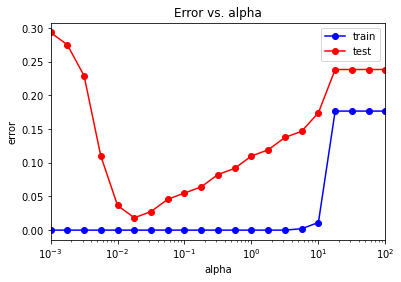

In [24]:
plt.semilogx(alpha_arr, train_err, 'b-o', label="train")
plt.semilogx(alpha_arr, test_err, 'r-o', label="test")
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()

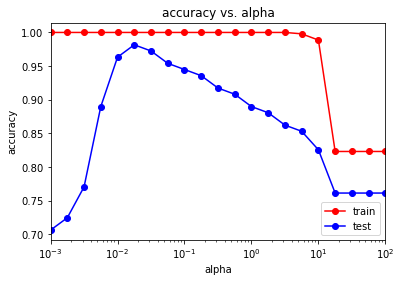

In [25]:
plt.semilogx(alpha_arr, train_acc, 'r-o', label="train")
plt.semilogx(alpha_arr, test_acc, 'b-o', label="test")
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('accuracy vs. alpha')
plt.xlabel('alpha')
plt.ylabel('accuracy')
plt.legend()

In [26]:
min_train_arr = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_arr, min_test_err)

0.0 0.01834862385321101


In [27]:
alpha_opt = alpha_arr[test_err  == min_test_err]
print(alpha_opt)

[0.01778279]


In [28]:
alpha_opt_two_layers = alpha_opt[0]

<h3>Найдём оптимально количество нейронов

<h5>Один слой

In [29]:
layer_sizes = np.arange(20, 200, 10)

In [30]:
test_err = []
train_err = []
train_acc = []
test_acc = []

for layer_size in layer_sizes:
    mlp_model = MLPClassifier(alpha=alpha_opt_one_layer,
                              hidden_layer_sizes = (layer_size,), 
                              solver='adam',
                              activation = 'logistic',
                              max_iter = 1000,
                              random_state=44
                              )
    mlp_model.fit(X_train, y_train)
    
    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))

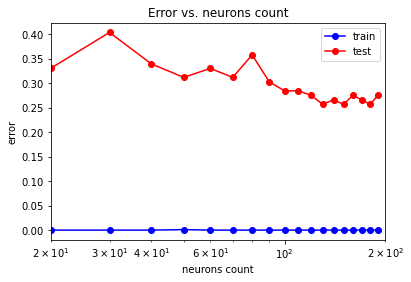

In [31]:
plt.semilogx(layer_sizes, train_err, 'b-o', label="train")
plt.semilogx(layer_sizes, test_err, 'r-o', label="test")
plt.xlim([np.min(layer_sizes), np.max(layer_sizes)])
plt.xlim([0,200])
plt.title('Error vs. neurons count')
plt.xlabel('neurons count')
plt.ylabel('error')
plt.legend()

In [32]:
min_train_arr = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_arr, min_test_err)

0.0 0.25688073394495414


In [33]:
size_opt = layer_sizes[test_err == min_test_err]
print(size_opt)

[130 150 180]


In [34]:
size_one_opt = size_opt[0]
size_one_opt

130

<h5>Два слоя

In [35]:
test_err = []
train_err = []
train_acc = []
test_acc = []

for layer_size in layer_sizes:
    mlp_model = MLPClassifier(alpha=alpha_opt_two_layers,
                            hidden_layer_sizes = (layer_size,layer_size,), 
                            solver='adam',
                            activation = 'logistic',
                            max_iter = 1000,
                            random_state=44
                                )
    mlp_model.fit(X_train, y_train)
        
    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
        
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))

ValueError: x and y must have same first dimension, but have shapes (18,) and (324,)

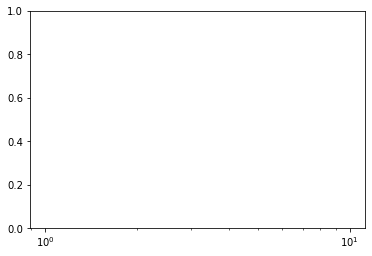

In [36]:
plt.semilogx(layer_sizes, train_err, 'b-o', label="train")
plt.semilogx(layer_sizes, test_err, 'r-o', label="test")
plt.xlim([np.min(layer_sizes), np.max(layer_sizes)])
plt.xlim([0,200])
plt.title('Error vs. neurons count')
plt.xlabel('neurons count')
plt.ylabel('error')
plt.legend()

In [ ]:
min_train_arr = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_arr, min_test_err)

0.0 0.01834862385321101


In [ ]:
size_opt = layer_sizes[test_err == min_test_err]
print(size_opt)

[90]


In [ ]:
size_two_opt = size_opt[0]
size_two_opt

90

<h3>Применяем классификатор с оптимальными параметрами

Один слой

In [ ]:
mlp_model_one = MLPClassifier(hidden_layer_sizes = (size_one_opt, ), alpha = alpha_opt_two_layers, random_state = 42, max_iter = 10000)
mlp_model_one.fit(X_train, y_train)

score1 = np.mean(y_train != mlp_model_one.predict(X_train))
score2 = np.mean(y_test  != mlp_model_one.predict(X_test))
print("Ошибка на обучающей выборке: ", score1)
print("Ошибка на тестовой выборке: ", score2)

Ошибка на обучающей выборке:  0.0
Ошибка на тестовой выборке:  0.12844036697247707


Два слоя

In [ ]:
mlp_model_two = MLPClassifier(hidden_layer_sizes = (size_two_opt, size_two_opt), alpha = alpha_opt_one_layer, random_state = 42, max_iter = 10000)
mlp_model_two.fit(X_train, y_train)

score1 = np.mean(y_train != mlp_model_two.predict(X_train))
score2 = np.mean(y_test  != mlp_model_two.predict(X_test))
print("Ошибка на обучающей выборке: ", score1)
print("Ошибка на тестовой выборке: ", score2)

Ошибка на обучающей выборке:  0.0
Ошибка на тестовой выборке:  0.14678899082568808


<h3>Матрица рассогласования

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(mlp_model, X_test, y_test)

$$TPR = \frac{TP}{P} = 48\% \\ $$
$$TNR = \frac{TN}{N} = 96\% \\ $$
$$FPR = \frac{FP}{N} = 4\% \\ $$
$$FNR = \frac{FN}{P} = 53\% \\ $$

<h3>Выводы</h3>
<ui>
<li> Оптимальное количество слоев = 
<li> Оптимальное количество нейронов =
<li> Оптимальное <code>alpha</code> = 
</ui>